# Pemodelan Citra Malam untuk Estimasi Kemiskinan Tahun 2023 ✈ 🗺



Sumber data yang digunakan:

*   Data SHP (Website Free)
*   Data Raster Citra Malam tahun 2023 > https://eogdata.mines.edu/nighttime_light/annual/v22/2023/
*   Data Persentase kemiskinan Per Kabko di Lampung 2023 (Website BPS Lampung)
*   Data Jumlah Penduduk per KabKo di Lampung 2023 (website BPS Lampung)
*   Data Kepadatan Penduduk per KabKo di Lampung 2023 (website BPS Lampung)




# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Install Package
!pip install geemap
!pip install rasterio
!pip install rasterstats
!pip install geopandas
!pip install shapely


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 5.5 MB/s eta 0:00:00


# Preparation Data

## Data Persentase Kemiskinan

In [3]:
import pandas as pd
datakemiskinan= pd.read_csv('/content/drive/MyDrive/Model Citra Malam Kemiskinan/PersentaseKemiskinanLampung.csv',delimiter=';')
datakemiskinan

,persentase,wilayah
0,11.17,Lampung Barat
1,10.52,Tanggamus
2,12.79,Lampung Selatan
3,13.80,Lampung Timur
4,10.65,Lampung Tengah
5,17.17,Lampung Utara
6,11.02,Way Kanan
7,8.04,Tulang Bawang
8,12.89,Pesawaran
9,9.14,Pringsewu


##Data Gabungan  Jumlah Penduduk & Kepadatan Penduduk

In [7]:
datagb= pd.read_csv('/content/drive/MyDrive/Model Citra Malam Kemiskinan/DataPersentaseMiskin-KepadatanPenduduk-JumlahPenduduk.csv',delimiter=',')
datagb

,persentase,wilayah,kepadatan,jumlah
0,11.17,Lampung Barat,147.65,312430
1,10.52,Tanggamus,228.31,662540
2,12.79,Lampung Selatan,498.01,1105000
3,13.80,Lampung Timur,295.44,1142580
4,10.65,Lampung Tengah,331.58,1508330
5,17.17,Lampung Utara,246.14,653850
6,11.02,Way Kanan,139.08,491110
7,8.04,Tulang Bawang,143.26,445170
8,12.89,Pesawaran,386.28,494280
9,9.14,Pringsewu,682.29,419590


In [8]:
datagb= datagb.drop('persentase', axis=1)
datagb

,wilayah,kepadatan,jumlah
0,Lampung Barat,147.65,312430
1,Tanggamus,228.31,662540
2,Lampung Selatan,498.01,1105000
3,Lampung Timur,295.44,1142580
4,Lampung Tengah,331.58,1508330
5,Lampung Utara,246.14,653850
6,Way Kanan,139.08,491110
7,Tulang Bawang,143.26,445170
8,Pesawaran,386.28,494280
9,Pringsewu,682.29,419590


# Preprocessing

## Clip Raster

100%|██████████| 15/15 [00:03<00:00,  4.84it/s]


    kota_id                                              image
0       1.0  [[[nan, nan, nan, nan, nan, nan, nan, nan, nan...
1       2.0  [[[nan, nan, nan, nan, nan, nan, nan, nan, nan...
2       3.0  [[[nan, nan, nan, nan, nan, nan, nan, nan, nan...
3       4.0  [[[nan, nan, nan, nan, nan, nan, nan, nan, nan...
4       5.0  [[[nan, nan, nan, nan, nan, nan, nan, nan, nan...
5       6.0  [[[nan, nan, nan, nan, nan, nan, nan, nan, nan...
6       7.0  [[[nan, nan, nan, nan, nan, nan, nan, nan, nan...
7       8.0  [[[nan, nan, nan, nan, nan, nan, nan, nan, nan...
8       9.0  [[[nan, nan, nan, nan, nan, nan, nan, nan, nan...
9      10.0  [[[nan, nan, nan, nan, nan, nan, nan, nan, nan...
10     11.0  [[[nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan...
11     12.0  [[[nan, nan, nan, nan, nan, nan, nan, nan, nan...
12     13.0  [[[nan, nan, nan, nan, nan, nan, nan, nan, nan...
13     14.0  [[[nan, nan, nan, nan, nan, nan, nan, nan, nan...
14     15.0  [[[nan, nan, nan, nan, nan, nan, nan, nan,

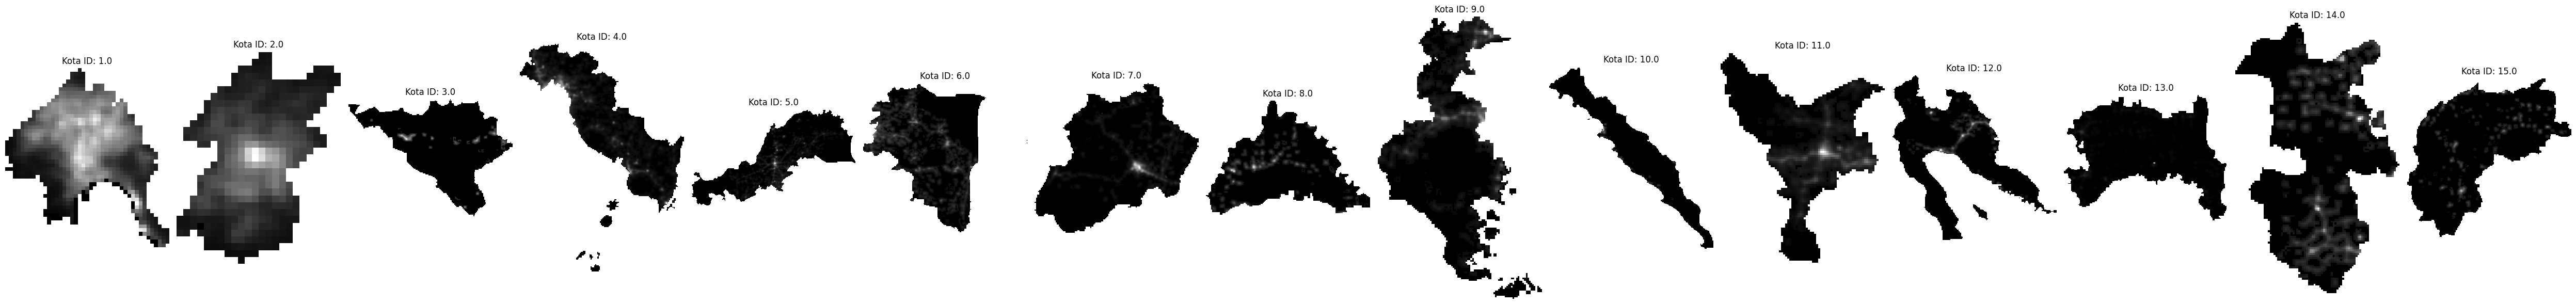

In [10]:
import rasterio
import rasterio.mask
import geopandas as gpd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Load shapefile kota
geom_kota = gpd.read_file('/content/drive/MyDrive/Model Citra Malam Kemiskinan/SHP Koka/SHPKoka.shp')
list_kota = geom_kota['fid'].unique()  # Asumsi ada kolom 'IDKOTA' sebagai pengidentifikasi unik untuk setiap kota

# Load file TIFF yang akan dipotong
tiff_file = '/content/drive/MyDrive/Model Citra Malam Kemiskinan/Citra Malam/Citr Lmpung 2023/LPG-VNL_npp_2023_global_vcmslcfg_v2_c202402081600.average_msked.tif'

# Menyiapkan directory untuk menyimpan hasil
hsil = '/content/drive/MyDrive/Model Citra Malam Kemiskinan/Clip'
if not os.path.exists(hsil):
    os.makedirs(hsil)

# Menyiapkan dictionary untuk menyimpan hasil potongan
potongan_tif = []

for kota_id in tqdm(list_kota):
    with rasterio.open(tiff_file) as src:
        shapes = geom_kota.query(f'fid == {kota_id}').geometry
        out_image, out_transform = rasterio.mask.mask(
            src, shapes, crop=True, all_touched=True, filled=True, nodata=np.nan
        )
        out_meta = src.meta
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        output_filename = os.path.join(hsil, f"{kota_id}_clip.tif")
        with rasterio.open(output_filename, "w", **out_meta) as dest:
            dest.write(out_image)

        # Menyimpan hasil potongan dalam dictionary
        potongan_tif.append({'kota_id': kota_id, 'image': out_image})

# Mengonversi hasil potongan ke DataFrame
df_potongan = pd.DataFrame(potongan_tif)

# Menampilkan DataFrame
print(df_potongan)

# Menampilkan hasil potongan TIFF
fig, axes = plt.subplots(nrows=1, ncols=len(potongan_tif), figsize=(50, 50))

for ax, entry in zip(axes, potongan_tif):
    image = entry['image']
    kota_id = entry['kota_id']
    ax.imshow(image[0], cmap='gray')
    ax.set_title(f'Kota ID: {kota_id}')
    ax.axis('off')

plt.tight_layout()
plt.show()


## Kalkulasi Nilai Intensitas raster

In [11]:
import rasterio
import rasterio.mask
import geopandas as gpd
from tqdm import tqdm
import numpy as np
import pandas as pd
import os

# Load shapefile kota
shapefile_path = '/content/drive/MyDrive/Model Citra Malam Kemiskinan/SHP Koka/SHPKoka.shp'
geom_kota = gpd.read_file(shapefile_path)
list_kota = geom_kota['fid'].unique()  # Asumsi ada kolom 'fid' sebagai pengidentifikasi unik untuk setiap kota

# Load file TIFF yang akan dipotong
tiff_file = '/content/drive/MyDrive/Model Citra Malam Kemiskinan/Citra Malam/Citr Lmpung 2023/LPG-VNL_npp_2023_global_vcmslcfg_v2_c202402081600.average_msked.tif'

# Menyiapkan dictionary untuk menyimpan hasil potongan
potongan_tif = []

for kota_id in tqdm(list_kota):
    with rasterio.open(tiff_file) as src:
        shapes = geom_kota.query(f'fid == {kota_id}').geometry
        out_image, out_transform = rasterio.mask.mask(
            src, shapes, crop=True, all_touched=True, filled=True, nodata=np.nan
        )
        # Mengambil nilai pixel sebagai array 1D
        pixel_values = out_image[0].flatten()

        # Menyimpan hasil potongan dalam dictionary
        potongan_tif.append({
            'kota_id': kota_id,
            'mean': np.nanmean(pixel_values),
            'median': np.nanmedian(pixel_values),# Contoh statistik, bisa disesuaikan
            'min': np.nanmin(pixel_values),
            'max': np.nanmax(pixel_values),
            'std': np.nanstd(pixel_values)
        })

# Mengonversi hasil potongan ke DataFrame
summarypixel = pd.DataFrame(potongan_tif)
summarypixel


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


,kota_id,mean,median,min,max,std
0,1.0,14.267408,13.571809,0.0,39.854919,9.208281
1,2.0,5.590641,4.576604,0.0,24.681845,3.786320
2,3.0,0.051913,0.000000,0.0,4.099058,0.255903
3,4.0,1.704472,1.234620,0.0,30.901598,2.408249
4,5.0,0.628573,0.000000,0.0,24.519270,1.212454
5,6.0,0.731206,0.000000,0.0,12.914245,0.962412
6,7.0,0.512427,0.000000,0.0,23.320255,1.344464
7,8.0,0.273480,0.000000,0.0,9.123581,0.649108
8,9.0,0.764815,0.000000,0.0,17.876234,1.318352
9,10.0,0.034469,0.000000,0.0,7.039932,0.228829


In [12]:
def encoding(data):
    encoding_map = {
        1.0: 'Bandar  Lampung',
        2.0: 'Metro',
        3.0: 'Lampung Barat',
        4.0: 'Lampung Selatan',
        5.0: 'Lampung Tengah',
        6.0: 'Lampung Timur',
        7.0: 'Lampung Utara',
        8.0: 'Mesuji',
        9.0: 'Pesawaran',
        10.0: 'Pesisir Barat',
        11.0: 'Pringsewu',
        12.0: 'Tanggamus',
        13.0: 'Tulang Bawang',
        14.0: 'Tulang Bawang barat',
        15.0: 'Way Kanan',
    }
    return [encoding_map[item] for item in data]

summarypixel['kota_id'] = encoding(summarypixel['kota_id'])
summarypixel


,kota_id,mean,median,min,max,std
0,Bandar Lampung,14.267408,13.571809,0.0,39.854919,9.208281
1,Metro,5.590641,4.576604,0.0,24.681845,3.786320
2,Lampung Barat,0.051913,0.000000,0.0,4.099058,0.255903
3,Lampung Selatan,1.704472,1.234620,0.0,30.901598,2.408249
4,Lampung Tengah,0.628573,0.000000,0.0,24.519270,1.212454
5,Lampung Timur,0.731206,0.000000,0.0,12.914245,0.962412
6,Lampung Utara,0.512427,0.000000,0.0,23.320255,1.344464
7,Mesuji,0.273480,0.000000,0.0,9.123581,0.649108
8,Pesawaran,0.764815,0.000000,0.0,17.876234,1.318352
9,Pesisir Barat,0.034469,0.000000,0.0,7.039932,0.228829


In [14]:
summarypixel.rename(columns={'kota_id': 'wilayah'}, inplace=True)
summarypixel

,wilayah,mean,median,min,max,std
0,Bandar Lampung,14.267408,13.571809,0.0,39.854919,9.208281
1,Metro,5.590641,4.576604,0.0,24.681845,3.786320
2,Lampung Barat,0.051913,0.000000,0.0,4.099058,0.255903
3,Lampung Selatan,1.704472,1.234620,0.0,30.901598,2.408249
4,Lampung Tengah,0.628573,0.000000,0.0,24.519270,1.212454
5,Lampung Timur,0.731206,0.000000,0.0,12.914245,0.962412
6,Lampung Utara,0.512427,0.000000,0.0,23.320255,1.344464
7,Mesuji,0.273480,0.000000,0.0,9.123581,0.649108
8,Pesawaran,0.764815,0.000000,0.0,17.876234,1.318352
9,Pesisir Barat,0.034469,0.000000,0.0,7.039932,0.228829


# Model & Evaluasi Model

##Random Forest

### Model & Evaluasi Model

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

X = pd.concat([summarypixel[['mean']], datagb[['kepadatan', 'jumlah']]], axis=1)
y = datakemiskinan['persentase']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisasi data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train_scaled, y_train)

# Make prediction
y_pred = rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions


Mean Squared Error: 3.9600524466666314


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


,Actual,Predicted
9,9.14,10.3669
11,7.25,10.3898
0,11.17,10.4513


### Korelasi Pearson

In [16]:
from scipy.stats import pearsonr

correlation, _ = pearsonr(y_test, y_pred)

print(f'Pearson Correlation: {correlation}')
if 0.90 <= correlation <= 1.00 or -1.00 <= correlation <= -0.90:
    print("Korelasi sangat kuat")
elif 0.70 <= correlation <= 0.89 or -0.89 <= correlation <= -0.70:
    print("Korelasi kuat")
elif 0.50 <= correlation <= 0.69 or -0.69 <= correlation <= -0.50:
    print("Korelasi moderat")
elif 0.30 <= correlation <= 0.49 or -0.49 <= correlation <= -0.30:
    print("Korelasi lemah")
elif 0.00 <= correlation <= 0.29 or -0.29 <= correlation <= 0.00:
    print("Korelasinya bisa diabaikan atau tidak terdapat korelasi")


Pearson Correlation: 0.7190068412127124
Korelasi kuat


## Decision Tree

### Model & Evaluasi Model

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
X = pd.concat([summarypixel[['mean']], datagb[['kepadatan', 'jumlah']]], axis=1)
y = datakemiskinan['persentase']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize data (standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Train the model
dt_regressor.fit(X_train_scaled, y_train)

# Make predictions
y_pred = dt_regressor.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predictions)


Mean Squared Error: 8.161166666666668
    Actual  Predicted
9     9.14      12.89
11    7.25       8.04
0    11.17       8.04


### Korelasi Pearson


In [18]:
from scipy.stats import pearsonr

correlation, _ = pearsonr(y_test, y_pred)

print(f'Pearson Correlation: {correlation}')
if 0.90 <= correlation <= 1.00 or -1.00 <= correlation <= -0.90:
    print("Korelasi sangat kuat")
elif 0.70 <= correlation <= 0.89 or -0.89 <= correlation <= -0.70:
    print("Korelasi kuat")
elif 0.50 <= correlation <= 0.69 or -0.69 <= correlation <= -0.50:
    print("Korelasi moderat")
elif 0.30 <= correlation <= 0.49 or -0.49 <= correlation <= -0.30:
    print("Korelasi lemah")
elif 0.00 <= correlation <= 0.29 or -0.29 <= correlation <= 0.00:
    print("Korelasinya bisa diabaikan atau tidak terdapat korelasi")


Pearson Correlation: -0.020615270438818223
Korelasinya bisa diabaikan atau tidak terdapat korelasi


## Linear Regression

### Model & Evaluasi Model

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

X = pd.concat([summarypixel[['mean']], datagb[['kepadatan', 'jumlah']]], axis=1)
y = datakemiskinan['persentase']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize data (standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Linear Regression model
lr_regressor = LinearRegression()

# Train the model
lr_regressor.fit(X_train_scaled, y_train)

# Make predictions
y_pred = lr_regressor.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predictions)


Mean Squared Error: 8.555015822471624
    Actual  Predicted
9     9.14  10.835755
11    7.25  10.913974
0    11.17   8.109811


### Korelasi Pearson


In [20]:
from scipy.stats import pearsonr

correlation, _ = pearsonr(y_test, y_pred)

print(f'Pearson Correlation: {correlation}')
if 0.90 <= correlation <= 1.00 or -1.00 <= correlation <= -0.90:
    print("Korelasi sangat kuat")
elif 0.70 <= correlation <= 0.89 or -0.89 <= correlation <= -0.70:
    print("Korelasi kuat")
elif 0.50 <= correlation <= 0.69 or -0.69 <= correlation <= -0.50:
    print("Korelasi moderat")
elif 0.30 <= correlation <= 0.49 or -0.49 <= correlation <= -0.30:
    print("Korelasi lemah")
elif 0.00 <= correlation <= 0.29 or -0.29 <= correlation <= 0.00:
    print("Korelasinya bisa diabaikan atau tidak terdapat korelasi")


Pearson Correlation: -0.8876919598605402
Korelasi kuat


##SVM Regressor

### Model & Evaluasi Model

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

X = pd.concat([summarypixel[['mean']], datagb[['kepadatan', 'jumlah']]], axis=1)
y = datakemiskinan['persentase']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize data (standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Support Vector Regression model
svm_regressor = SVR(kernel='rbf')  # Using RBF kernel for non-linear regression

# Train the model
svm_regressor.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svm_regressor.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predictions)


Mean Squared Error: 4.969554039578193
    Actual  Predicted
9     9.14  10.754663
11    7.25  10.611235
0    11.17  10.168187


### Korelasi Pearson

In [22]:
from scipy.stats import pearsonr

correlation, _ = pearsonr(y_test, y_pred)

print(f'Pearson Correlation: {correlation}')
if 0.90 <= correlation <= 1.00 or -1.00 <= correlation <= -0.90:
    print("Korelasi sangat kuat")
elif 0.70 <= correlation <= 0.89 or -0.89 <= correlation <= -0.70:
    print("Korelasi kuat")
elif 0.50 <= correlation <= 0.69 or -0.69 <= correlation <= -0.50:
    print("Korelasi moderat")
elif 0.30 <= correlation <= 0.49 or -0.49 <= correlation <= -0.30:
    print("Korelasi lemah")
elif 0.00 <= correlation <= 0.29 or -0.29 <= correlation <= 0.00:
    print("Korelasinya bisa diabaikan atau tidak terdapat korelasi")


Pearson Correlation: -0.7386324013639455
Korelasi kuat


## GBoost Regressor

### Model & Evaluasi Model

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Data preparation
X = pd.concat([summarypixel[['mean']], datagb[['kepadatan', 'jumlah']]], axis=1)
y = datakemiskinan['persentase']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisasi data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Train the model
gbr.fit(X_train_scaled, y_train)

# Make predictions
y_pred = gbr.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (Gradient Boosting): {mse}')
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions


Mean Squared Error (Gradient Boosting): 4.847871470788932


,Actual,Predicted
9,9.14,8.691615
11,7.25,7.836784
0,11.17,7.428576


### Korelasi Pearson

In [24]:
from scipy.stats import pearsonr

correlation, _ = pearsonr(y_test, y_pred)

print(f'Pearson Correlation: {correlation}')
if 0.90 <= correlation <= 1.00 or -1.00 <= correlation <= -0.90:
    print("Korelasi sangat kuat")
elif 0.70 <= correlation <= 0.89 or -0.89 <= correlation <= -0.70:
    print("Korelasi kuat")
elif 0.50 <= correlation <= 0.69 or -0.69 <= correlation <= -0.50:
    print("Korelasi moderat")
elif 0.30 <= correlation <= 0.49 or -0.49 <= correlation <= -0.30:
    print("Korelasi lemah")
elif 0.00 <= correlation <= 0.29 or -0.29 <= correlation <= 0.00:
    print("Korelasinya bisa diabaikan atau tidak terdapat korelasi")

Pearson Correlation: -0.33614989595433276
Korelasi lemah


## AdaBoost Regressor

### Model & Evaluasi Model

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Data preparation
X = pd.concat([summarypixel[['mean']], datagb[['kepadatan', 'jumlah']]], axis=1)
y = datakemiskinan['persentase']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisasi data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the AdaBoost Regressor
abr = AdaBoostRegressor(random_state=42)

# Train the model
abr.fit(X_train_scaled, y_train)

# Make predictions
y_pred = abr.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (AdaBoost Regressor): {mse}')
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions


Mean Squared Error (AdaBoost Regressor): 7.191954166666663


,Actual,Predicted
9,9.14,11.4175
11,7.25,7.6600
0,11.17,7.1425


### Korelasi Pearson


In [26]:
from scipy.stats import pearsonr

correlation, _ = pearsonr(y_test, y_pred)

print(f'Pearson Correlation: {correlation}')
if 0.90 <= correlation <= 1.00 or -1.00 <= correlation <= -0.90:
    print("Korelasi sangat kuat")
elif 0.70 <= correlation <= 0.89 or -0.89 <= correlation <= -0.70:
    print("Korelasi kuat")
elif 0.50 <= correlation <= 0.69 or -0.69 <= correlation <= -0.50:
    print("Korelasi moderat")
elif 0.30 <= correlation <= 0.49 or -0.49 <= correlation <= -0.30:
    print("Korelasi lemah")
elif 0.00 <= correlation <= 0.29 or -0.29 <= correlation <= 0.00:
    print("Korelasinya bisa diabaikan atau tidak terdapat korelasi")

Pearson Correlation: -0.13136491318939122
Korelasinya bisa diabaikan atau tidak terdapat korelasi


## XGBoost

### Model & Evaluasi Model

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Data preparation
X = pd.concat([summarypixel[['mean']], datagb[['kepadatan', 'jumlah']]], axis=1)
y = datakemiskinan['persentase']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisasi data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the XGBRegressor
xgb = XGBRegressor(random_state=42)

# Train the model
xgb.fit(X_train_scaled, y_train)

# Make predictions
y_pred = xgb.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions


Mean Squared Error: 5.876683416082995


,Actual,Predicted
9,9.14,10.581488
11,7.25,7.646286
0,11.17,7.246338


### Korelasi Pearson


In [29]:
from scipy.stats import pearsonr

correlation, _ = pearsonr(y_test, y_pred)

print(f'Pearson Correlation: {correlation}')
if 0.90 <= correlation <= 1.00 or -1.00 <= correlation <= -0.90:
    print("Korelasi sangat kuat")
elif 0.70 <= correlation <= 0.89 or -0.89 <= correlation <= -0.70:
    print("Korelasi kuat")
elif 0.50 <= correlation <= 0.69 or -0.69 <= correlation <= -0.50:
    print("Korelasi moderat")
elif 0.30 <= correlation <= 0.49 or -0.49 <= correlation <= -0.30:
    print("Korelasi lemah")
elif 0.00 <= correlation <= 0.29 or -0.29 <= correlation <= 0.00:
    print("Korelasinya bisa diabaikan atau tidak terdapat korelasi")

Pearson Correlation: -0.1302763315157191
Korelasinya bisa diabaikan atau tidak terdapat korelasi


#Hasil





Model Estimasi dibangun dengan fitur Mean Intensitas Raster per Kabupaten/Kota, Kepadatan Penduduk & Jumlah Penduduk dengan test (uji) estimasi menggunakan data persentase kemiskinan per Kabupaten/Kota oleh Badan Pusat Statistik Provinsi Lampung diperoleh hasil MSE & Uji Korelasi Pearson



| Model | MSE | Korelasi Pearson |
|---|---|---|
| Random Forest |  3.9601 | Korelasi Kuat |
| GBoost Regressor |  4.8478 | Korelasi Lemah|
| SVM Regressor | 4.9695 | Korelasi Kuat |
| XGBoost | 5.8767 | Tidak Berkorelasi |
| adaboost Regressor | 7.1919 | Tidak Berkorelasi |
| Decision Tree | 8.1612 | Tidak Berkorelasi |
| Linear Regression | 8.5550 | Korelasi Kuat |


Beberapa model telah menunjukkan Korelasi Kuat antara Estimasi dengan data test, walaupun beberapa model memiliki korelasi lemah ataupun tidak berkorelasi. Hal ini bisa disebabkan karena data yang di Train terbilang sedikit sehingga mempengaruhi Keakuratan Model. Untuk menciptakan model akurat dengan menambah data, atau memperbarui skala data diambil, misalnya mengunakan data persentase kemiskinan Kabupaten/Kota di Indonesia ataupun data persentase kemiskinan per desa di Lampung

# Peta Persebaran Intesitas Cahaya dari Citra Malam

diolah menggunakan Qgis

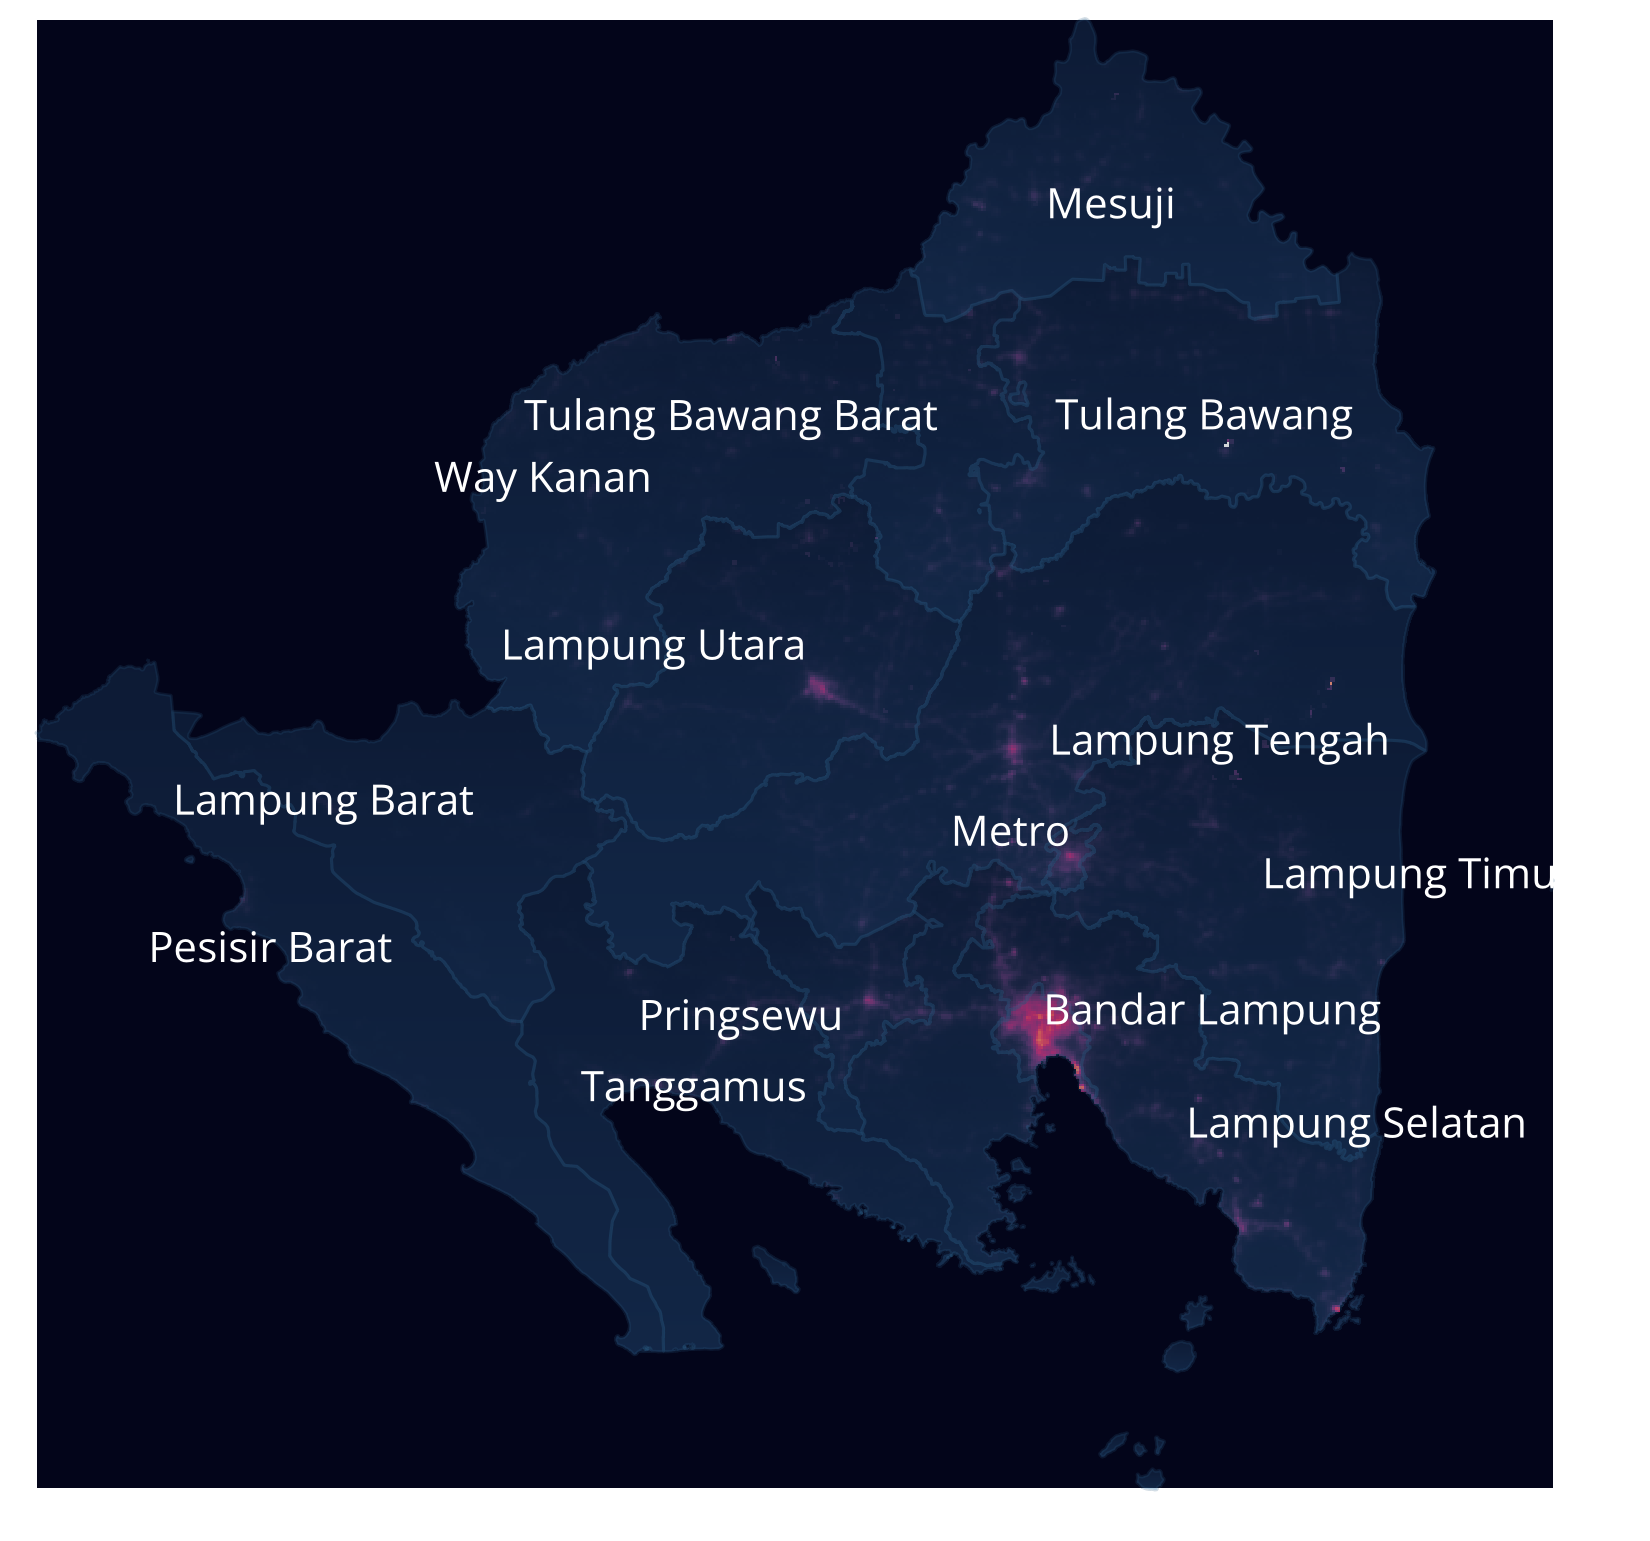

Terlihat Kabupaten Kota Intesitas Cahaya dari Citra Malam di Provinsi Lampung, pada Kabupaten Pesisir Barat & Lampung Barat memiliki intensitas sangat rendah. Dan Kabupaten/Kota memiliki Intensitas Cahaya Paling Terang pada wilayah perkotaan yaitu Bandar Lampung dan Metro serta pada Kabupaten Lampung Selatan & Lampung Tengah. Dari Intensitas Cahaya disuatu wilayah yang tinggi bisa menunjukkan wilayah tersebut memiliki persentase Kemiskinan yang kecil daripada wilayah dengan Intensitas Cahaya yang kecil

